In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio
!pip install tensorflow

In [ ]:
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import matplotlib.gridspec as grid
import tensorflow as tf

In [ ]:
img = rio.open('/content/drive/MyDrive/THARAKA_S2_2019_AUG_DEC_cloud_13_Seasonal.tif')
img.bounds
   
   

BoundingBox(left=37.30775240171102, bottom=-0.4515830933268834, right=38.30937394350428, top=0.06863128770673144)

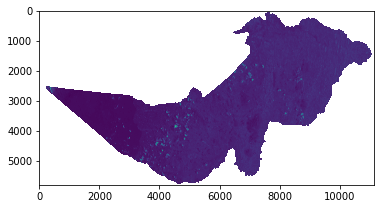

In [ ]:
img = rio.open('/content/drive/MyDrive/THARAKA_S2_2019_AUG_DEC_cloud_13_Seasonal.tif').read(1)
show(img)

In [ ]:
tharaka_raster = rio.open('/content/drive/MyDrive/THARAKA_S2_2019_AUG_DEC_cloud_13_Seasonal.tif')
print(tharaka_raster.meta)
tharaka_arr = tharaka_raster.read() # read the opened image
vmin, vmax = np.nanpercentile(tharaka_arr, (5,95))  # 5-95% contrast stretch


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 11150, 'height': 5791, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 37.30775240171102,
       0.0, -8.983152841195215e-05, 0.06863128770673144)}


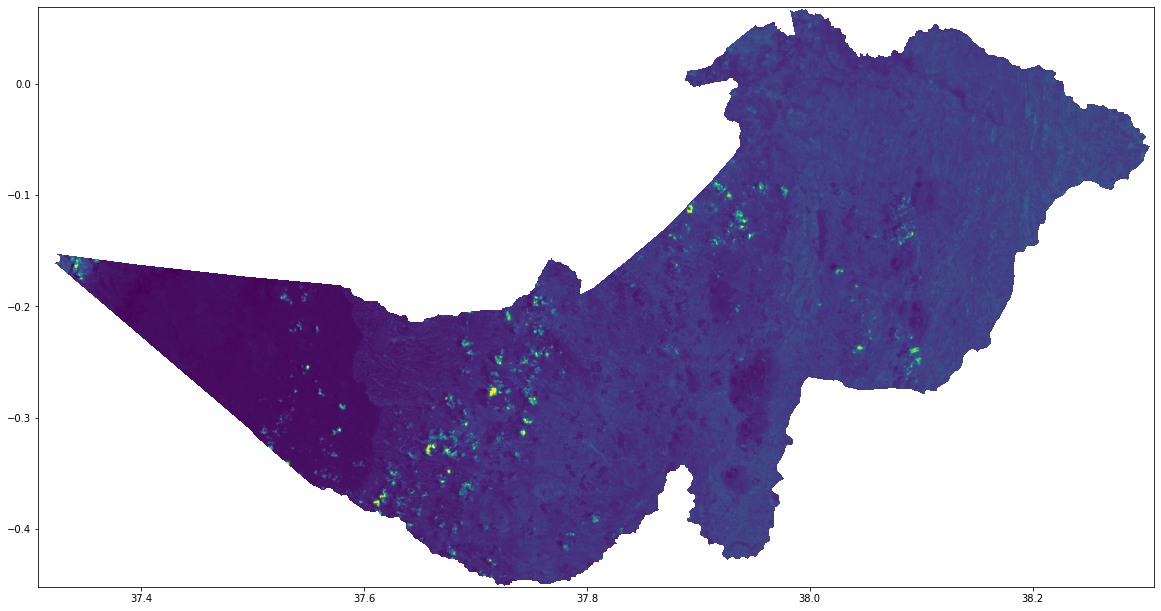

In [ ]:
plt.figure(figsize=[20,20])
show(tharaka_raster, vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
# create an empty array with same dimension and data type
imgxyb = np.empty((tharaka_raster.height, tharaka_raster.width, tharaka_raster.count), tharaka_raster.meta['dtype'])
# loop through the raster's bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = tharaka_raster.read(band+1)

In [ ]:
imgxyb[np.isnan(imgxyb)] = 0

imgxy = imgxyb[1000:3000, 7000:9000, 0:6]

imgxy.shape

(2000, 2000, 6)

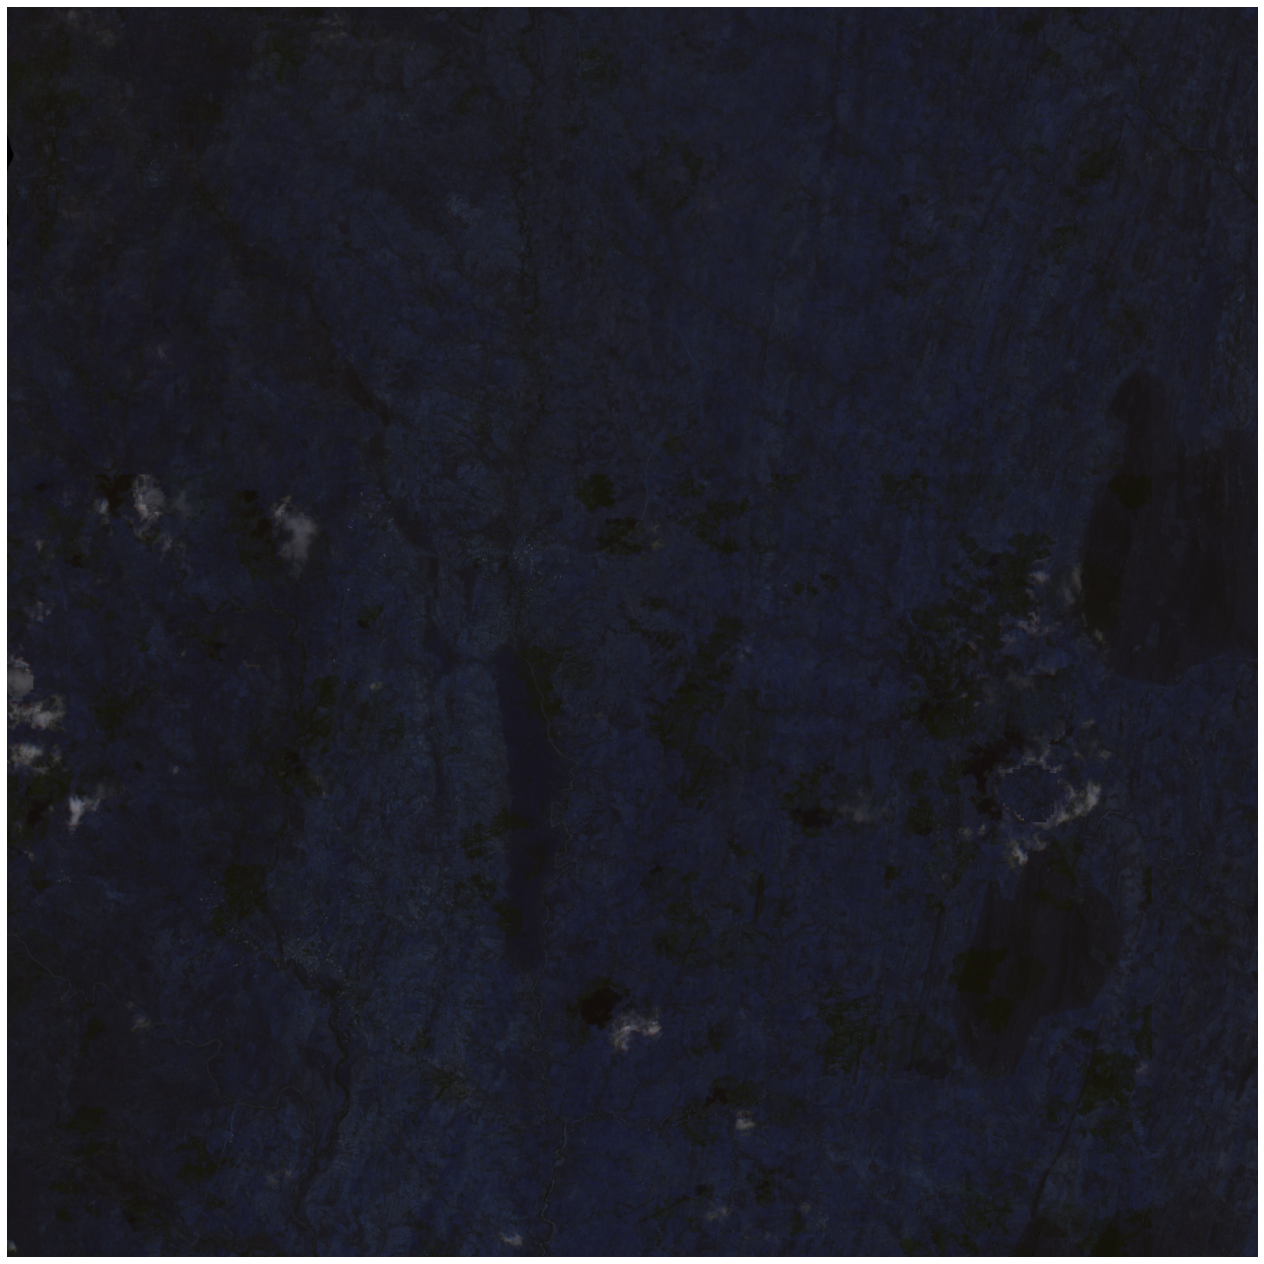

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
axes.imshow(imgxy[:,:,0:3].astype('float32'))
axes.axis('off');


In [ ]:

fig,axes = plt.subplots(2,3,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities at Different Bandwidth in the visible and Infra-red spectrum', fontsize=30)
n_bands = 6

axes = axes.ravel()
for i in range(n_bands):
    axes[i].imshow(imgxy[:,:,i], vmin=vmin, vmax=vmax)
    axes[i].set_title('band '+str(i+1),fontsize=25)
    axes[i].axis('off')
#fig.delaxes(axes[-1])

In [ ]:

fig,axes = plt.subplots(2,3,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities at Different Bandwidth in the visible and Infra-red spectrum', fontsize=30)
n_bands = 6

axes = axes.ravel()
for i in range(n_bands):
    axes[i].imshow(imgxy[:,:,i], cmap='gray')
    axes[i].set_title('band '+str(i+1),fontsize=25)
    axes[i].axis('off')
#fig.delaxes(axes[-1])

In [ ]:
# Convert 2d band array in 1-d to make them as feature vectors and Standardization  
n_bands = 6
MB_matrix = np.empty((imgxy[:,:,0].size,n_bands), tharaka_raster.meta['dtype'])

for i in range(n_bands):
    MB_array = imgxy[:,:,i].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  # Standardize each variable 
    MB_matrix[:,i] = MB_arrayStd
MB_matrix.shape

(4000000, 6)

In [ ]:
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)
EigVal

array([4.479, 0.839, 0.492, 0.123, 0.037, 0.03 ])

In [ ]:
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

In [ ]:
def py_matmul(a, b):
    ra, ca = a.shape
    rb, cb = b.shape
    assert ca == rb, f"{ca} != {rb}"
    
    return tf.matmul(a, b)
MB_matrix = MB_matrix.astype('float32')
EigVec = EigVec.astype('float32')

tf_a = tf.constant(MB_matrix)
tf_b = tf.constant(EigVec)

PC = py_matmul(tf_a,tf_b)

In [ ]:
PC.numpy()

array([[-2.559e+00,  8.665e-01, -6.586e-01, -7.683e-02, -3.742e-02,
         5.383e-02],
       [-2.801e+00,  5.658e-01, -3.334e-01,  9.568e-02,  2.872e-02,
         1.660e-02],
       [-2.715e+00,  3.743e-01, -3.199e-01, -3.538e-01, -3.911e-02,
         7.925e-02],
       ...,
       [ 1.965e+00,  5.888e-02,  3.825e-02,  5.159e-01,  1.894e-02,
         1.050e-01],
       [ 2.341e+00,  3.138e-02, -7.264e-02,  5.807e-01,  1.540e-04,
         2.436e-02],
       [ 2.425e+00,  6.439e-02, -3.142e-01,  6.142e-01, -1.681e-02,
         4.491e-02]], dtype=float32)

Text(0.5, 0.98, 'Pair plot of PCs')

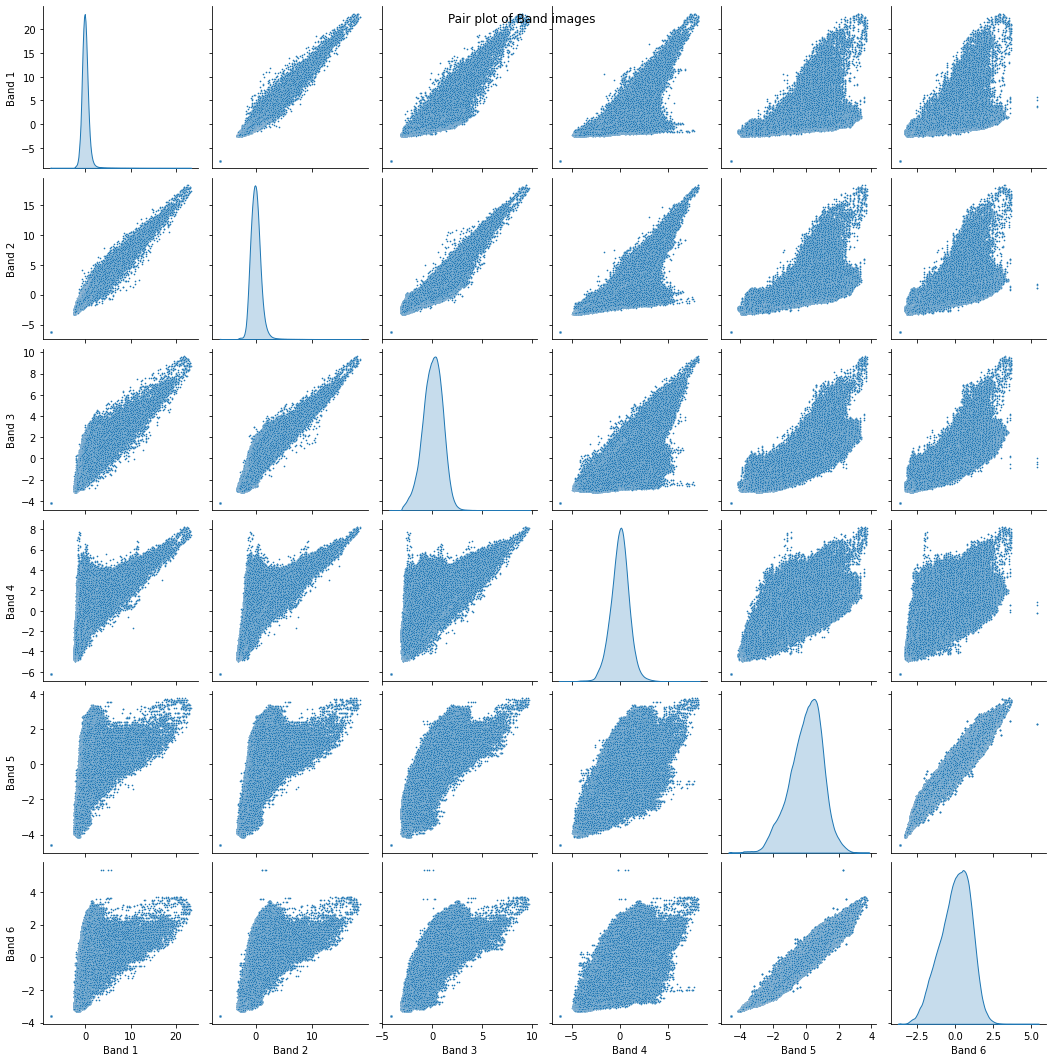

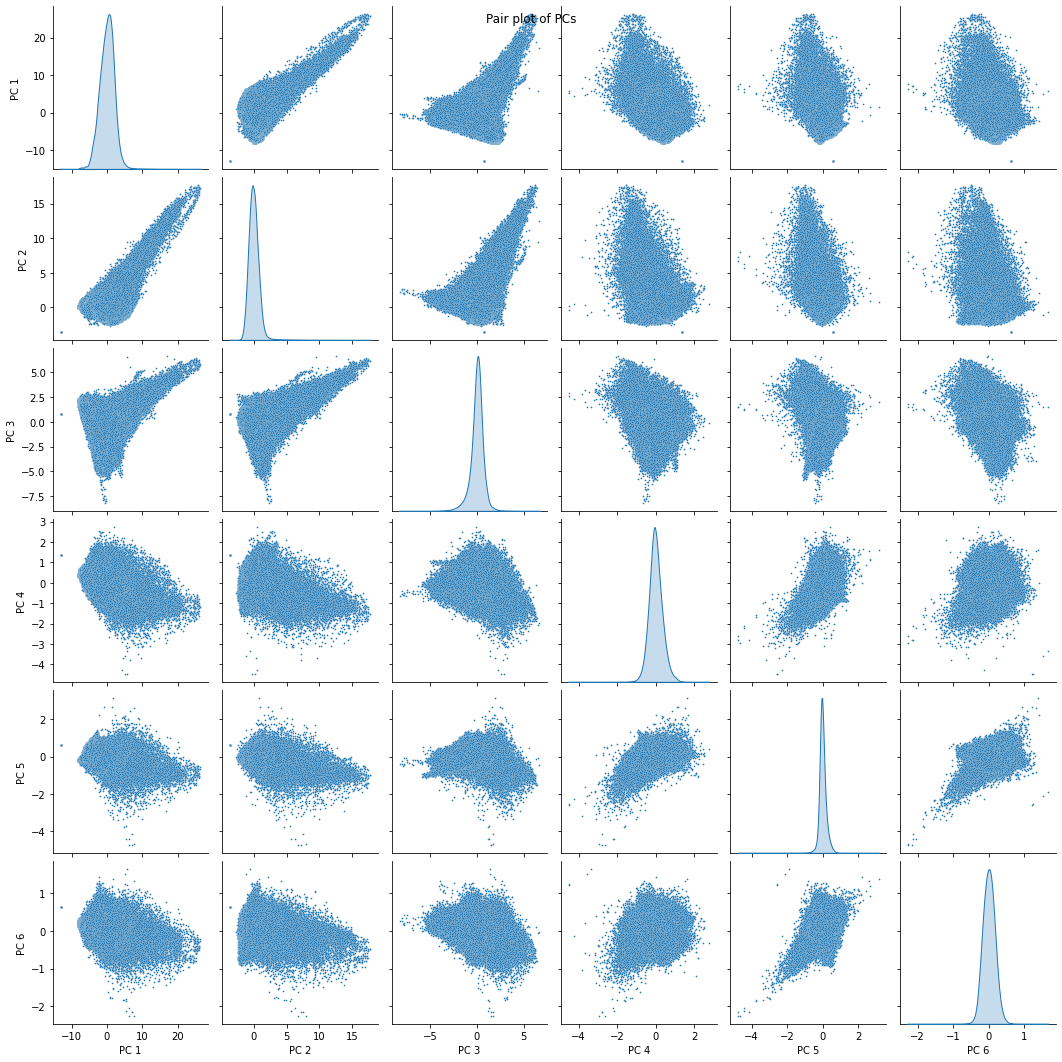

In [ ]:
# Generate Paiplot for original data and transformed PCs 
import seaborn as sns
a = sns.pairplot(pd.DataFrame(MB_matrix,columns = ['Band 1','Band 2','Band 3','Band 4','Band 5','Band 6']),diag_kind='kde',plot_kws={"s": 3})
a.fig.suptitle("Pair plot of Band images")
b = sns.pairplot(pd.DataFrame(PC, columns = ['PC 1','PC 2','PC 3','PC 4','PC 5','PC 6']),diag_kind='kde',plot_kws={"s": 3})
b.fig.suptitle("Pair plot of PCs")


First three PCs retain 96 % of information


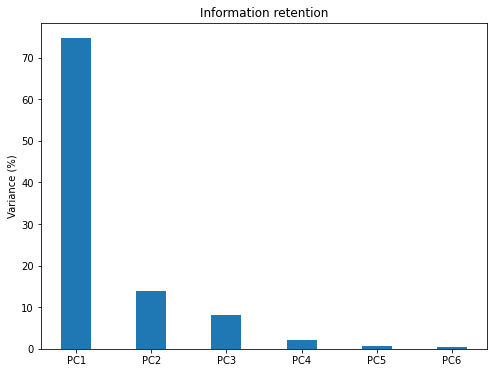

In [ ]:
#Information Retained by Principal Components
plt.figure(figsize=(8,6))
plt.bar([1,2,3,4,5,6],EigVal/sum(EigVal)*100,align='center',width=0.4,tick_label = ['PC1','PC2','PC3','PC4','PC5','PC6'])
plt.ylabel('Variance (%)')
plt.title('Information retention');

print("\nFirst three PCs retain "+str(int(sum(EigVal[:3])/sum(EigVal)*100))+" % of information")

In [ ]:
np.save('/content/drive/MyDrive/pc_cropped.npy', PC) 

In [ ]:
PC = np.load('/content/drive/MyDrive/pc_cropped.npy')
PC.shape

(4000000, 6)

In [ ]:
img_shape = (2000, 2000)
PC_2d = np.zeros((img_shape[0],img_shape[1],6))
for i in range(6):
    PC_2d[:,:,i] = PC[:,i].reshape(-1,img_shape[1])

In [ ]:
n_bands = 6
PC_2d_Norm = np.zeros((img_shape[0],img_shape[1],n_bands))
for i in range(n_bands):
    PC_2d_Norm[:,:,i] = cv2.normalize(PC_2d[:,:,i],  np.zeros(img_shape),0,255 ,cv2.NORM_MINMAX)

In [ ]:
PC_2d_Norm.shape

(2000, 2000, 6)

In [ ]:
np.save('/content/drive/MyDrive/PC_2d_norm_cropped.npy', PC_2d_Norm) 

In [ ]:
PC_2d_Norm = np.load('/content/drive/MyDrive/PC_2d_norm_cropped.npy')
PC_2d_Norm.shape

(2000, 2000, 6)

In [ ]:
fig,axes = plt.subplots(2,3,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities of Principal Components ', fontsize=30)


axes = axes.ravel()
for i in range(6):
    
    axes[i].imshow(PC_2d_Norm[:,:,i])#, vmin=vmin, vmax=vmax)
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')


In [ ]:
fig,axes = plt.subplots(2,3,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities of Principal Components ', fontsize=30)


axes = axes.ravel()
for i in range(6):
    
    axes[i].imshow(PC_2d_Norm[:,:,i], cmap = 'gray')
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Comparision of RGB image and principal components composite image', fontsize=30)

axes[0].imshow(imgxy[:,:,0:3].astype('float32'))
axes[0].axis('off');
#axes[1].figure(figsize=(img_shape[0]/150,img_shape[1]/150))
axes[1].imshow(PC_2d_Norm[:,:,0:3][:,:,[0,1,2]].astype(int))
axes[1].axis('off');